In [1]:
import multiprocessing as mp
import netket as nk
import os
import json
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from functools import reduce
from time import time
from scipy.optimize import minimize
from matplotlib import gridspec
import copy
import pickle
import optax

In [2]:
def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace


#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()
    

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

def exactDiagonalization_full(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

#Construct Hamiltonian
def hamiltonian(N,B,Ak):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += Ak[n]*sz_list[0]*sz_list[n+1] + Ak[n]*sx_list[0]*sx_list[n+1] + Ak[n]*sy_list[0]*sy_list[n+1]
    return H

In [172]:
#Gives the Evolution 
def evolve(H, psi0, observable,times):

    result = sesolve(H, psi0, times, observable)
    expect = result.expect[0]
    return expect

#basis transfer fuction, from a basis of eigenstates to a basis of "basis states"
def transfer(state_eig, sta_list, eng_list, N):
    state_basis = np.zeros(2**N, dtype= 'complex128')
    for i in range(len(eng_list)):
        state_basis += state_eig[i] * sta_list[i]
    return state_basis #/ np.linalg.norm(state_basis)

#construct the S+0 and S-0 operators of interest
def S0_p(N):
    S0_p = []
    si = qeye(2)
    op_list = []
    for m in range(N):     
        op_list.append(si)
    op_list[0] = sigmap()
    S0_p.append(tensor(op_list))
    
    return S0_p[0]

def S0_m(N):
    S0_m = []
    si = qeye(2)
    op_list = []
    for m in range(N):     
        op_list.append(si)
    op_list[0] = sigmam()
    S0_m.append(tensor(op_list))
    
    return S0_m[0]

def H1_coeff(t, args):
    return 0.05 * np.exp(-0.5*(t / 40 - 4)**2) 

def H1_coeff_(t):
    return 0.05 * np.exp(-0.5*(t / 40 - 4)**2) 


In [173]:
N=6
B=0.95
A = N/2
N0 = N/2

Ak = []
for i in range(N-1):
        # Constant A
    #Ak_i = 1
        # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)

# Define hamiltonian and hilbert space
ha, hi = CSHam(N,B,Ak)


#Exact Diagonalization
e, v = exactDiagonalization_full(ha)

sx_list, sy_list, sz_list,id = operatorCreation(N)
obver_x = [sx_list[0]]
obver_y = [sy_list[0]]

a = np.array([[1], [0],[0],[0],[0]]).tolist()
for i in range(2**N-5):
    a.append([0])
psi0 = np.array(a, dtype = 'complex128')/ np.linalg.norm(a)

times = np.linspace(0,1000,50000)


#Make initial State
psi0 = Qobj(transfer(psi0,v,e,N))
H0 = hamiltonian(N, B, Ak)
H1 = -sy_list[0]
obver_p = [S0_p(N)]
H = [H0,[H1, H1_coeff]]




In [174]:
results = evolve(H,psi0,obver_x,times)


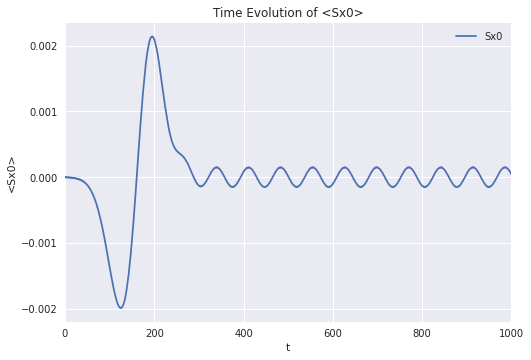

In [175]:
plt.plot(times, np.real(results), label = 'Sx0')

plt.title('Time Evolution of <Sx0>')
plt.ylabel("<Sx0>")
plt.xlabel("t")
plt.xlim(0,1000)
plt.legend()
plt.show()

In [176]:
#evolve correlation function
def evo_corr(t_obver, obver, sta_list, eng_list, t_end, t_step, N):
    num_step = int(np.around(t_end / t_step))
    time = []
    correlation = []
    
    coeff = np.ones(len(eng_list), dtype = complex)
    
    for i in range(num_step+1):
        time.append(t_step*(i))
        corr_temp = complex(0,0)
        
        for j in range(len(eng_list)):
            op = np.exp(- 1j * (eng_list[j]-eng_list[0]) * t_step)
            coeff[j] = op * coeff[j]
            ket_j = coeff[j] * sta_list[j]
            corr_temp += expected_2(t_obver, sta_list[0], ket_j) * expected_2(obver, sta_list[j], sta_list[0])
        
        correlation.append(corr_temp)
            
    return time, correlation

def expected_2(A, bra, ket):
        
    expectation = np.dot(np.conj(bra).T, np.matmul(A, ket) )
    return expectation

#evolve correlation function of negative time
def evo_corr_nega(t_obver, obver, sta_list, eng_list, t_end, t_step, N):
    num_step = int(np.around(t_end / t_step))
    time = []
    correlation = []
    
    coeff = np.ones(len(eng_list), dtype = complex)
    
    for i in range(num_step+1):
        time.append(t_step*(i))
        corr_temp = complex(0,0)
        
        for j in range(len(eng_list)):
            op = np.exp(1j * (eng_list[j]-eng_list[0]) * t_step)
            coeff[j] = op * coeff[j]
            ket_j = coeff[j] * sta_list[j]
            corr_temp += expected_2(t_obver, sta_list[0], ket_j) * expected_2(obver, sta_list[j], sta_list[0])
        
        correlation.append(corr_temp)
            
    return time, correlation

In [177]:
def g(t_end, t_step):
    a = []
    num_step = int(np.around(t_end / t_step))
    for i in range(num_step+1):
        a.append(H1_coeff_(t_end - t_step * i))
    #a.reverse() 
    
    return np.array(a)

def susceptibility(A, B, sta_list, eng_list, t_end, t_step, N):
    sus = 1j * (np.array(evo_corr(A, B , sta_list, eng_list, t_end, t_step, N)[1], dtype = complex)
                       - np.array(evo_corr_nega(B, A, sta_list, eng_list, t_end, t_step, N)[1], dtype = complex)) 
    
    time = (evo_corr(A, B, sta_list, eng_list, t_end, t_step, N)[0])
            
    return time, sus

In [178]:
#take real or imaginary intergrand, not mixed
def integral(time, sus, t_step):
    result = []
    for i in range(len(time)):
        intergrand = sus[:i+1] * g((i)* t_step, t_step)
        result_temp = scipy.integrate.simpson(y = intergrand, x=time[:i+1])
        result.append(result_temp)
    return result
    
def integral_faster(time, sus, t_step):
    result = [0]
    result_temp = float(0)
    for i in range(len(time)-1):
        intergrand = sus * g((len(time)-1)* t_step, t_step)
        result_temp += float(scipy.integrate.simpson(y = intergrand[i:i+2], x=time[i:i+2]))
        result.append(result_temp)
    return result
    

In [189]:
B_y = np.array(sy_list[0])
A_x = np.array(sx_list[0])

t_end = 1000
t_step = 0.1


time = susceptibility(A_x, B_y, v[:5], e[:5], t_end, t_step, N)[0]
sus_real =  np.real(susceptibility(A_x, B_y, v[:5], e[:5], t_end, t_step, N)[1])
sus_imag =  np.imag(susceptibility(A_x, B_y, v[:5], e[:5], t_end, t_step, N)[1])
print(sus_imag)

[0. 0. 0. ... 0. 0. 0.]


In [190]:
result_real = integral(time, sus_real, t_step)
#result_imag = integral(time, sus_imag, t_step)

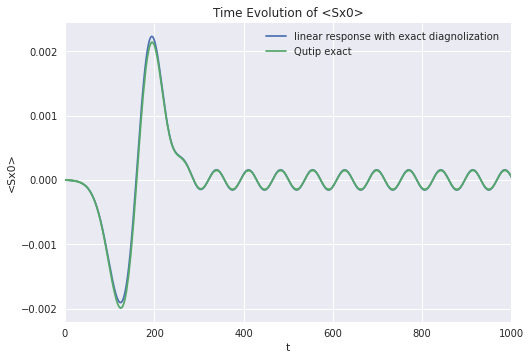

In [191]:
plt.plot(time, result_real, label = 'linear response with exact diagnolization ')
plt.plot(times, np.real(results), label = 'Qutip exact')
plt.title('Time Evolution of <Sx0>')
plt.ylabel("<Sx0>")
plt.xlabel("t")
plt.xlim(0,1000)
plt.legend()
plt.show()

In [182]:
eng_list = np.loadtxt("2021_summer_data/temp_data/eng_4.json")
state_list = np.loadtxt("2021_summer_data/temp_data/state_4.json", dtype = complex)
print(eng_list)

[-1.41525147 -1.32781556 -1.27152273 -1.21981863 -1.19888325]


In [183]:
sus_real_rbm =  np.real(susceptibility(A_x, B_y, state_list, eng_list, t_end, t_step, N)[1])
sus_imag_rbm =  np.imag(susceptibility(A_x, B_y, state_list, eng_list, t_end, t_step, N)[1])
print(sus_imag_rbm)

[-1.40946282e-18 -9.75781955e-19 -1.13841228e-18 ... -8.67361738e-19
  8.67361738e-19  1.73472348e-18]


In [184]:
result_real_rbm = integral(time, sus_real_rbm, t_step)

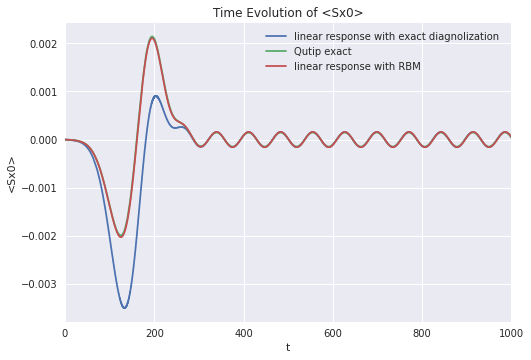

In [185]:
plt.plot(time, result_real, label = 'linear response with exact diagnolization ')
plt.plot(times, np.real(results), label = 'Qutip exact')
plt.plot(time, result_real_rbm, label = 'linear response with RBM')
plt.title('Time Evolution of <Sx0>')
plt.ylabel("<Sx0>")
plt.xlabel("t")
#plt.hlines(0.002, 0, 500, color='y')
plt.xlim(0,1000)
plt.legend()
plt.show()

In [35]:
print(np.abs(e[0]-e[1]))

0.0875371119095103


Text(0.5, 0, 'tau')

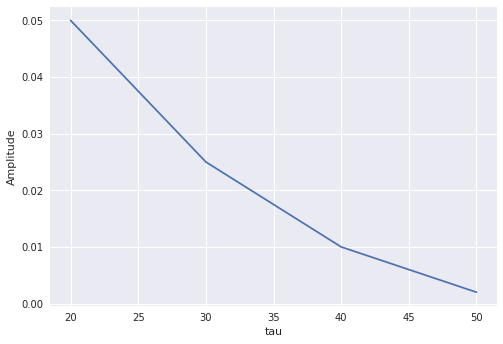

In [126]:
c = [0.05,0.025,0.01, 0.002]
d = [20, 30, 40, 50]

plt.plot(d,c)
plt.ylabel('Amplitude')
plt.xlabel('tau')

In [25]:
a = np.array([1,2])
b = np.array([2,3])
print(scipy.integrate.simpson(b,a))

2.5


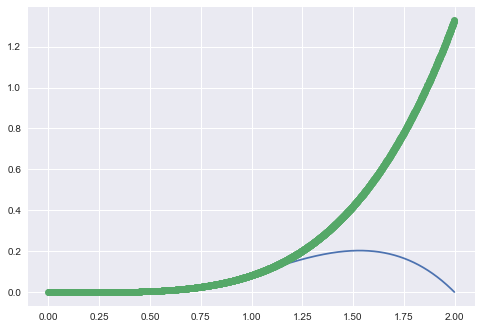

In [21]:
delta = 0.001
t = np.arange(1000) * delta
a = t
b = t**2
c = np.convolve(a, b, 'same') * delta
e = np.convolve(a, b) * delta
d = t**4 / 12
t2 = np.arange(len(e)) * delta
f = t2**4/12
#plt.plot(np.arange(len(c)) * delta, c)
plt.plot(np.arange(len(e)) * delta, e)
plt.plot()
plt.plot(t2, f, 'o')

plt.show()

In [6]:
print(c.shape)

(1999,)
